In [ ]:
!pip install optuna -q

import pandas as pd
import numpy as np
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

In [ ]:
train_df = pd.read_csv('/content/train_Sleep_health_and_lifestyle_dataset.csv')
val_df = pd.read_csv('/content/val_Sleep_health_and_lifestyle_dataset.csv')
test_df = pd.read_csv('/content/test_Sleep_health_and_lifestyle_dataset.csv')

In [ ]:
# Separando features (X) e target (y)
target = 'Quality of Sleep'
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_val = val_df.drop(columns=[target])
y_val = val_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]

In [ ]:
# Salvando a ordem das colunas para o Streamlit
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'colunas_modelo.joblib')

['colunas_modelo.joblib']

In [ ]:
def objective(trial):
    # Parâmetros que o Optuna vai tentar otimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 15),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    }

    # Cria e treina o modelo temporário
    model = RandomForestRegressor(**params)

    # Cross-Validation no treino todo unindo X_train e X_val para ter mais dados no Cross-Val
    X_full = pd.concat([X_train, X_val])
    y_full = pd.concat([y_train, y_val])

    scores = cross_val_score(model, X_full, y_full, cv=5, scoring='neg_mean_absolute_error')

    return -scores.mean()

# Cria e roda o optuna
study = optuna.create_study(direction='minimize')
print("\nIniciando busca de hiperparâmetros")
study.optimize(objective, n_trials=100) # usando 100 tentativas

print(f"\n Melhores parâmetros: {study.best_params}")

[I 2026-01-28 14:32:29,379] A new study created in memory with name: no-name-fb1a21a6-33df-4c47-a1f6-3f49be59e39a



Iniciando busca de hiperparâmetros


[I 2026-01-28 14:32:30,634] Trial 0 finished with value: 0.24872951668449902 and parameters: {'n_estimators': 117, 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 0 with value: 0.24872951668449902.
[I 2026-01-28 14:32:37,566] Trial 1 finished with value: 0.35818497158425266 and parameters: {'n_estimators': 372, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.24872951668449902.
[I 2026-01-28 14:32:40,606] Trial 2 finished with value: 0.25364820579047176 and parameters: {'n_estimators': 125, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 0 with value: 0.24872951668449902.
[I 2026-01-28 14:32:47,048] Trial 3 finished with value: 0.1991660524814671 and parameters: {'n_estimators': 311, 'max_depth': 13, 'min_samples_split': 28, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.199


 Melhores parâmetros: {'n_estimators': 310, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'log2'}


In [ ]:
# Treinando o modelo final com os melhores parâmetros
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features='log2', min_samples_leaf=4,
                      min_samples_split=11, n_estimators=310, random_state=42)

In [ ]:
# Avaliação Final
def evaluation(model, X, y, nome_set):
    preds = model.predict(X)

    mae = mean_absolute_error(y, preds)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, preds)
    med_ae = median_absolute_error(y, preds)

    print(f"Resultados no Dataset de {nome_set}")
    print(f"R² (Explicação da variância): {r2:.4f}")
    print(f"MAE (Erro médio absoluto):    {mae:.4f}")
    print(f"RMSE (Penaliza erros grandes): {rmse:.4f}")
    print(f"MedAE (Erro típico/mediana):  {med_ae:.4f}")
    print(f"MSE (Erro quadrático médio):  {mse:.4f}")
    print("----------------------------------------")

In [ ]:
# Avaliar em Validação e Teste
evaluation(final_model, X_val, y_val, "Validação")
evaluation(final_model, X_test, y_test, "Teste Final")

Resultados no Dataset de Validação
R² (Explicação da variância): 0.9847
MAE (Erro médio absoluto):    0.0601
RMSE (Penaliza erros grandes): 0.1514
MedAE (Erro típico/mediana):  0.0263
MSE (Erro quadrático médio):  0.0229
----------------------------------------
Resultados no Dataset de Teste Final
R² (Explicação da variância): 0.9615
MAE (Erro médio absoluto):    0.0795
RMSE (Penaliza erros grandes): 0.2347
MedAE (Erro típico/mediana):  0.0200
MSE (Erro quadrático médio):  0.0551
----------------------------------------


In [ ]:
# Salvando o modelo final para o Streamlit
joblib.dump(final_model, 'modelo_sleep.joblib')

['modelo_sleep.joblib']

In [ ]:
# Checando as previsões vs os resultados reais no dataset de teste
preds_test = final_model.predict(X_test)
print("Primeiras 20 previsões vs reais (Teste):\n", pd.DataFrame({'Real': y_test[:20], 'Predito': preds_test[:20]}))

Primeiras 10 previsões vs reais (Teste):
     Real   Predito
0      6  6.018509
1      6  6.003907
2      6  6.018509
3      6  6.013530
4      7  6.947053
5      8  8.017937
6      8  7.975465
7      6  6.013654
8      9  8.926162
9      8  7.981012
10     7  7.009006
11     7  6.881675
12     8  7.971734
13     9  8.967222
14     8  8.004074
15     8  7.991404
16     7  7.031296
17     6  6.017533
18     8  8.005720
19     8  7.990278


In [ ]:
# Checando a importância das features
importances = final_model.feature_importances_
feat_importance = pd.DataFrame({'feature': X_test.columns, 'importance': importances}).sort_values('importance', ascending=False)
print("Top 10 Features:\n", feat_importance.head(10))

Top 10 Features:
                             feature  importance
1                    Sleep Duration    0.231004
3                      Stress Level    0.165776
4                        Heart Rate    0.132573
0                               Age    0.110244
2           Physical Activity Level    0.077437
5                       Daily Steps    0.076795
6                      BMI Category    0.058657
16  Occupation_Sales Representative    0.025610
22            Sleep Disorder_Normal    0.023720
23       Sleep Disorder_Sleep Apnea    0.020925


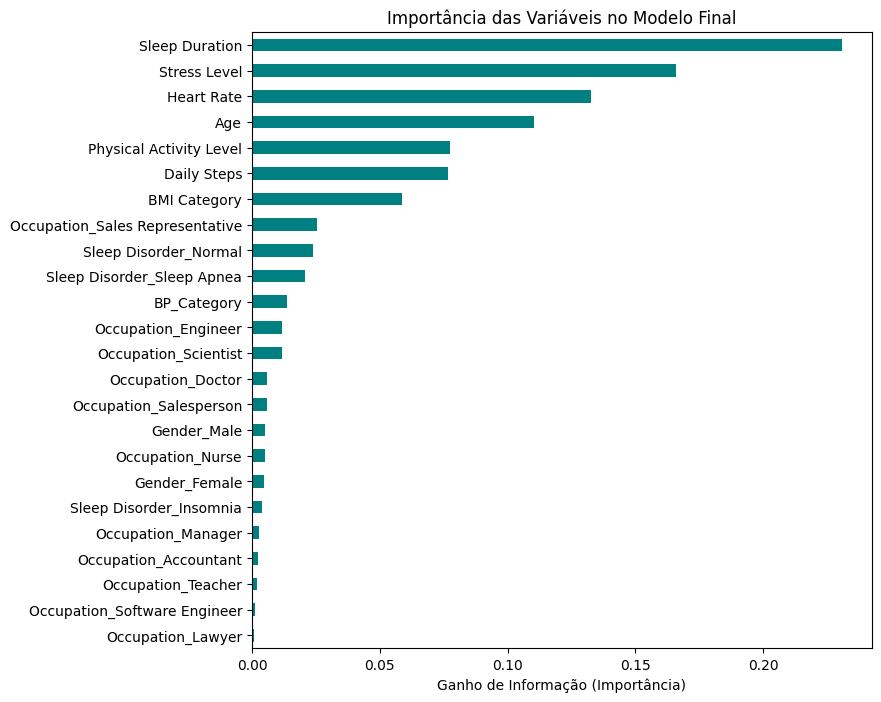

In [ ]:
# Importância das Variáveis
importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 8))
importances.plot(kind='barh', color='teal')
plt.title("Importância das Variáveis no Modelo Final")
plt.xlabel("Ganho de Informação (Importância)")
plt.show()

In [ ]:
# Análise de resíduos no teste
residuals = y_test - preds_test
print("Estatísticas de resíduos (Teste):")
print("Média:", residuals.mean())
print("Desvio padrão:", residuals.std())
print("Resíduos > 0.5:", (abs(residuals) > 0.5).sum())

Estatísticas de resíduos (Teste):
Média: 0.015157915882056306
Desvio padrão: 0.23634217617615755
Resíduos > 0.5: 2


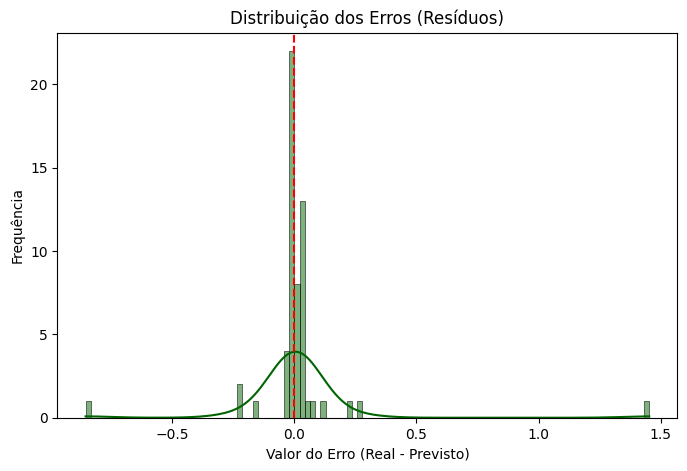

In [ ]:
# Histograma de erros
residuos = y_test - preds_test

plt.figure(figsize=(8, 5))
sns.histplot(residuos, kde=True, color='darkgreen')
plt.title("Distribuição dos Erros (Resíduos)")
plt.xlabel("Valor do Erro (Real - Previsto)")
plt.ylabel("Frequência")
plt.axvline(0, color='red', linestyle='--') # O erro ideal é zero
plt.show()

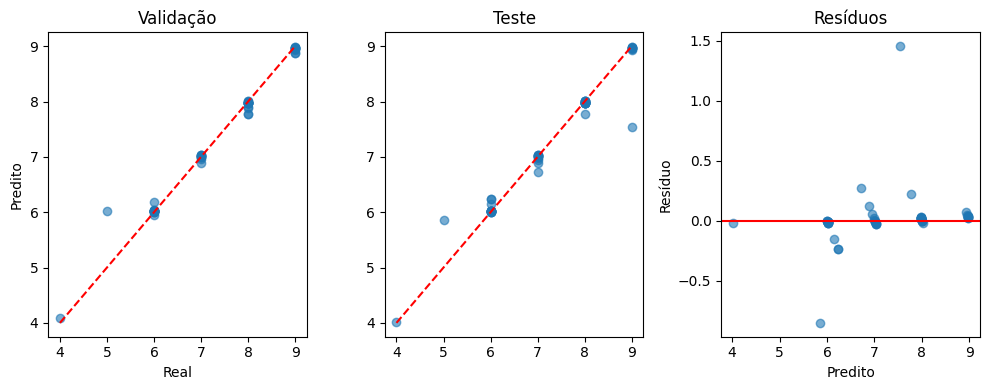

In [ ]:
# Scatter plots real vs predito + resíduos
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.scatter(y_val, final_model.predict(X_val), alpha=0.6); plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--'); plt.xlabel('Real'); plt.ylabel('Predito'); plt.title('Validação')
plt.subplot(1,3,2); plt.scatter(y_test, preds_test, alpha=0.6); plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--'); plt.title('Teste')
residuals_test = y_test - preds_test
plt.subplot(1,3,3); plt.scatter(preds_test, residuals_test, alpha=0.6); plt.axhline(0, color='r'); plt.xlabel('Predito'); plt.ylabel('Resíduo'); plt.title('Resíduos')
plt.tight_layout(); plt.show()

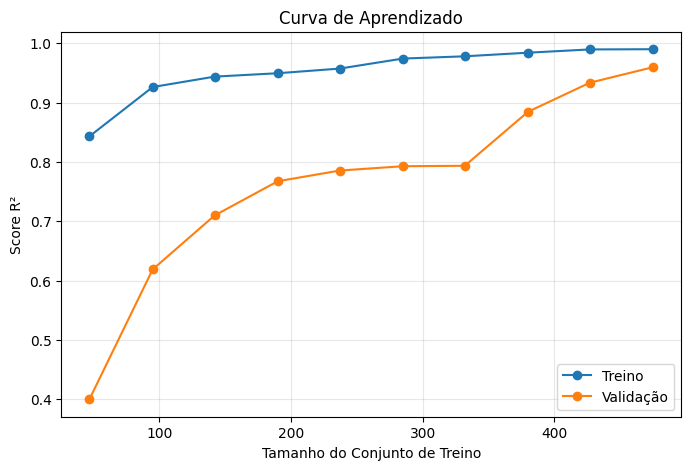

In [ ]:
# Curva de aprendizado
plt.figure(figsize=(8, 5))
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Treino")
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label="Validação")
plt.title("Curva de Aprendizado")
plt.xlabel("Tamanho do Conjunto de Treino")
plt.ylabel("Score R²")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()